# How to build a Toolbox

In diesem Tutorial wird an zwei Beispielen erklärt, wie man sich in Python eine Toolbox zur Datenvisualisierung baut.
Ziel ist es dabei, den Zusammenhang zwischen Input- und Outputdaten von Pick-and-Place-Versuchen zunächst visuell zu analysieren zu können und dabei potentielle Muster zu finden, die einen Rückschluss auf das zugrundeliegende mathematische Modell erlauben. 

Im ersten Beispiel werden die K nächsten Nachbarn eines ausgewählten Datenpunkts auf Basis einer Abstandsmetrik dynamisch berechnet und angezeigt. Im zweiten Beispiel wird K-Means Clustering auf den Datensatz angewendet. Die Zahl der Cluster kann dabei vorgegeben und das Clustering von Schritt zu Schritt beobachtet werden.

## Neighborhood Toolbox

Zunächst werden die notwendigen Importe durchgeführt.

In [1]:
import csv
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button

Der untersuchte Datensatz hat folgende Struktur: 

| X-In | Y-In | Angle-In | X-Delta | Y-Delta | Angle-Delta |
|------|------|----------|---------|---------|-------------|
|   ...| ...  |    ...   |    ...  |    ...  |     ...     |
|   X  |  Y   |   A      |    dX   |    dY   |      dA     |

Für den Datensatz und die Toolbox wird jeweils eine separate Klasse definiert. Für die einzelnen Spalten des Datensatzes werden dabei die Klassenvariablen X, Y, A, dX, dY und dA initialisiert.

Aufgabe dieser Toolbox ist es, die nächsten Nachbarn eines bestimmten Punkts im Datensatz zu finden und diese Nachbarschaften im Datensatz graphisch zu visualisieren. Die die aktuell gewählte Teilmenge des Datensatzes, aus der die Nachbarschaft besteht, wird in den Listen X_N, Y_N, dX_N und dY_N gespeichert.

Zunächst wird die Klasse für den Datensatz angelegt.

In [2]:
class Dataset:

    def __init__(self):
        self.X = []                         # input x coordinate
        self.Y = []                         # input y coordinate
        self.A = []                         # input angle coordinate
        self.dX = []                        # output delta x
        self.dY = []                        # output delta y
        self.dA = []                        # output delta angle
        self.X_N = []                       # input x coordinate of nearest neighbors
        self.Y_N = []                       # input y coordinate of nearest neighbors
        self.dX_N = []                      # output x coordinate of nearest neighbors
        self.dY_N = []                      # output y coordinate of nearest neighbors
        self.number_of_points = 0           # total number of data points       

Im nächsten Schritt werden die Daten aus dem Excel-File importiert. Die Daten liegen im Unterordner 'dataset'.
Dazu wird die Methode __read_data__ definiert. Diese liest die Eingangsdaten spaltenweise aus und schreibt diese in die Listen  X, Y (Aufnahmeposition) und A (Aufnahmewinkel). Analog werden die Ausgangsdaten in den Listen dX, dY (Ablagefehler) und dA (Winkelfehler) geschrieben und von der Funktion zurückgegeben.

Zu beachten ist, dass es hierbei zwei Optionen zum Auslesen der Daten gibt, da die zugrundeliegenden Excel-Dateien leicht unterschiedliche Formate haben. Die Option wird wie folgt ausgewählt:
* option=1 --> kapace-Datensatz
* option=2 --> data_1 und data_2

In [3]:
    def read_data(self, input_file, option=1):

        # The training and test data will be saved in these lists
        inputs, outputs = [], []

        # Read training.csv and extract the necessary data
        with open(input_file) as csvfile:
            readTrainingCSV = csv.reader(csvfile, delimiter=';')
            for row in readTrainingCSV:
                if len(row) < 9:
                    continue
                try:
                    inputs.append(np.array([float(row[2]), float(row[3]), float(row[4])]))
                    if option == 1:
                        outputs.append(np.array([float(row[6]), float(row[7]), float(row[8])]))
                    if option == 2:
                        outputs.append(np.array([float(row[5]), float(row[6]), float(row[7])]))

                except:
                    print("Row skipped")

        # Data pre-processing
        self.X, self.Y, self.A, self.dX, self.dY, self.dA = [], [], [], [], [], []

        # Write the data to vectors for each column
        for i in range(0, len(inputs)):
            self.X.append(inputs[i][0])
            self.Y.append(inputs[i][1])
            self.A.append(inputs[i][2])
            self.dX.append(outputs[i][0])
            self.dY.append(outputs[i][1])
            self.dA.append(outputs[i][2])

        self.number_of_points = len(self.X)
    
    setattr(Dataset, 'read_data', read_data)
    


Später wird der gewünschte Datensatz mithilfe dieser Funktion importiert. 
Folgende Datensätze sind vorhanden:
* 'kapace_training.csv'
* 'kapace_test.csv'
* 'data_1_training.csv'
* 'data_1_test.csv'
* 'data_2_training.csv'
* 'data_2_test.csv'


Jetzt folgt die Klasse für die Toolbox selbst. Der Datensatz wird der Toolbox als Objekt übergeben, das in der Init-Funktion als Klassenvariable gespeichert wird.

In [4]:
class DataToolbox:

    def __init__(self, data):
        # Establish new dataset object and read the data
        self.data = data
        self.selected_point = 0             # list index of currently selected point
        self.number_of_points = 0           # total number of data points
        self.number_of_neighbors = 50       # size of neighborhood
        self.angle_weight = 0               # angle weight for calculation of the neighborhood

        self.fig, (self.ax1, self.ax2) = plt.subplots(1, 2)
        self.non_slider = Slider(self.ax1, 'init', 0, 0, valinit=0, valstep=0)
        self.curr_slider = Slider(self.ax1, 'init', 0, 0, valinit=0, valstep=0)
        self.ang_slider = Slider(self.ax1, 'init', 0, 0, valinit=0, valstep=0)

In [5]:
data = Dataset()
data.read_data('dataset/kapace_training.csv', 1)
print("\nX data:")
print(data.X[0:10])
print("\nY data:")
print(data.Y[0:10])
print("\nA data:")
print(data.A[0:10])


X data:
[-105.633217, 44.234489, 81.083237, -60.191307, -144.103363, 58.458729, -122.544769, 139.763397, 123.717308, 3.215348]

Y data:
[-40.209, 124.547, -6.78798, -93.8554, -95.2377, -101.349, -125.203, 81.1558, -4.92106, 63.428]

A data:
[-55.9356, 74.6226, 22.9036, 43.922, -23.2359, -63.6357, 24.8599, 16.9214, 17.0562, -56.9046]


Als nächstes wird eine Methode definiert, um die K nächsten Nachbarn eines Punkts der Input-Daten zu finden. Dazu ein Punkt ausgewählt und der Abstand im Merkmalsraum zu allen anderen Nachbarn berechnet. Da der Aufnahmewinkel [°] eine andere Einheit besitzt als die Aufnahmeposition [mm], wird folgendes Distanzmaß für die Nähe zweier Punkte definiert:

$d=\sqrt[]{\Delta x^2 + \Delta y^2 + \alpha \Delta a^2}$

Mit dem Parameter $\alpha$ lässt sich der Einfluss des Winkels auf die berechnete Distanz einstellen.

In [6]:
    def update_neighbors(self, data):

        alpha = self.angle_weight
        k = self.selected_point

        # Calculate distances to all other points
        distances = []
        for j in range(0, len(data.X)):
            delta_x = data.X[k] - data.X[j]
            delta_y = data.Y[k] - data.Y[j]
            delta_a = data.A[k] - data.A[j]
            distances.append(np.sqrt(delta_x ** 2 + delta_y ** 2 + alpha * delta_a ** 2))

        # Find nearest neighbors
        neighbors = []
        for i in range(0, self.number_of_neighbors + 1):
            min_dist_pos = int(np.argmin(distances))
            min_dist_val = np.amin(distances)

            if min_dist_val > 0:                            # ensure that the current point is excluded
                neighbors.append(min_dist_pos)              # save new neighbor
            distances[min_dist_pos] = np.infty              # 'delete' value from minimum candidates list

        # Write neighbor lists
        self.data.X_N, self.data.Y_N, self.data.dX_N, self.data.dY_N = [], [], [], []
        for i in neighbors:
            data.X_N.append(data.X[i])
            data.Y_N.append(data.Y[i])
            data.dX_N.append(data.dX[i])
            data.dY_N.append(data.dY[i])
        
    setattr(DataToolbox, 'update_neighbors', update_neighbors)

Im nächsten Schritt muss eine Methode zum Plotten der Daten her, durch die die ermittelten
Nachbarschaften entsprechend hervorgehoben werden. Folgende Eingabeparameter sind hierzu notwendig:

Dazu werden die Punkte auf der auf der Input- und Outputseite farblich markiert.

In [7]:
    def plot_data(self, data):
        ax = self.ax1
        ax.cla()
        ax.scatter(data.X, data.Y, marker='o', s=8)
        ax.scatter(data.X_N, data.Y_N, marker='o', c='darkorange', s=8)
        ax.scatter(data.X[self.selected_point], data.Y[self.selected_point], marker='o', c='red', s=10)
        ax.axhline(y=0, color='gray', linewidth=0.5)
        ax.axvline(x=0, color='gray', linewidth=0.5)
        ax.set_aspect('equal')
        ax.grid(True, which='both', linewidth=0.5, linestyle='--')
        ax.set_title("Input data")

        ax = self.ax2
        ax.cla()
        ax.scatter(data.dX, data.dY, marker='o', s=8, color='red')
        ax.scatter(data.dX_N, data.dY_N, marker='o', c='black', s=8)
        ax.scatter(data.dX[self.selected_point], data.dY[self.selected_point], marker='o', c='gray', s=10)
        ax.axhline(y=0, color='gray', linewidth=0.5)
        ax.axvline(x=0, color='gray', linewidth=0.5)
        ax.set_aspect('equal')
        ax.grid(True, which='both', linewidth=0.5, linestyle='--')
        ax.set_title("Output data")
        
    setattr(DataToolbox, 'plot_data', plot_data)

Jetzt wird der Plot für die Daten eingerichtet. Dazu wird ein Fenster mit zwei Subplots erzeugt und es werden Slider angelegt, mit deren Hilfe man sich durch den Datensatz bewegen kann. Es lassen sich einstellen:

* Anzahl der Nachbarn
* Punkt im Datensatz
* Angle-Weight-Faktor

In [8]:
    def create_figure(self):
        self.fig.canvas.set_window_title('Neighborhood Toolbox')
        self.update_neighbors(self.data)
        self.plot_data(self.data)
        self.fig.show()

        # create interactive elements
        axcolor = 'lightblue'
        pos1 = plt.axes([0.25, 0.1, 0.65, 0.03], facecolor=axcolor)
        pos2 = plt.axes([0.25, 0.15, 0.65, 0.03], facecolor=axcolor)
        pos3 = plt.axes([0.25, 0.05, 0.35, 0.03], facecolor=axcolor)
        self.non_slider = Slider(pos2, 'Neighbors', 1, 250, valinit=50, valstep=1)
        self.curr_slider = Slider(pos1, 'Choose Pt.', 0, data.number_of_points-1, valinit=0, valstep=1)
        self.ang_slider = Slider(pos3, 'Angle weight', 0, 10, valinit=0, valstep=1)
        resetax = plt.axes([0.8, 0.025, 0.1, 0.04])
        button = Button(resetax, 'Reset', color=axcolor, hovercolor='0.975')

        self.non_slider.on_changed(self.updated)
        self.curr_slider.on_changed(self.updated)
        self.ang_slider.on_changed(self.updated)
        button.on_clicked(self.button_pressed)

        plt.subplots_adjust(left=0.1, right=0.9)
        plt.show()

    setattr(DataToolbox, 'create_figure', create_figure)

Jetzt fehlen noch zwei Callback-Funktionen, welche auf Änderungen in Slider-Werten oder die Betätigung des Reset-Buttons  reagieren und dafür sorgen, dass die Plots entsprechend aktualisiert werden.

In [9]:
    def updated(self, val):
        self.number_of_neighbors = int(self.non_slider.val)
        self.selected_point = int(self.curr_slider.val)
        self.angle_weight = self.ang_slider.val
        self.update_neighbors(self.data)
        self.plot_data(self.data)
        self.fig.show()

    def button_pressed(self, event):
        self.ax1.cla()
        self.ax2.cla()
        self.non_slider.reset()
        self.curr_slider.reset()
        self.ang_slider.reset()
        
    setattr(DataToolbox, 'updated', updated)
    setattr(DataToolbox, 'button_pressed', button_pressed)

Der Start der Toolbox geschieht dann über folgenden Aufruf:

<ipython-input-4-a04c07e5326d>:12: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
  self.non_slider = Slider(self.ax1, 'init', 0, 0, valinit=0, valstep=0)
<ipython-input-4-a04c07e5326d>:13: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
  self.curr_slider = Slider(self.ax1, 'init', 0, 0, valinit=0, valstep=0)
<ipython-input-4-a04c07e5326d>:14: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
  self.ang_slider = Slider(self.ax1, 'init', 0, 0, valinit=0, valstep=0)
<ipython-input-8-a21432f61b80>:5: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


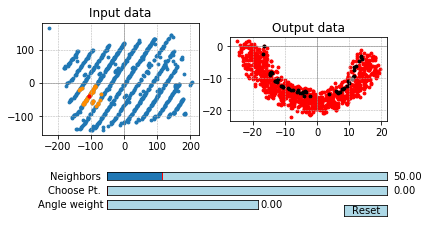

In [10]:
tb = DataToolbox(data)
tb.create_figure()

## Clustering Toolbox

In [11]:
import csv
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button, TextBox
from sklearn.cluster import KMeans

Hier wird erneut zunächst der betreffende Datensatz geladen und ein Objekt erzeugt, welches die Daten enthält.

In [12]:
data = Dataset()
data.read_data('dataset/kapace_training.csv')
print("\nX data:")
print(data.X[0:10])
print("\nY data:")
print(data.Y[0:10])
print("\nA data:")
print(data.A[0:10])


X data:
[-105.633217, 44.234489, 81.083237, -60.191307, -144.103363, 58.458729, -122.544769, 139.763397, 123.717308, 3.215348]

Y data:
[-40.209, 124.547, -6.78798, -93.8554, -95.2377, -101.349, -125.203, 81.1558, -4.92106, 63.428]

A data:
[-55.9356, 74.6226, 22.9036, 43.922, -23.2359, -63.6357, 24.8599, 16.9214, 17.0562, -56.9046]


Hier wird wieder eine Klasse für die zweite Toolbox angelegt.

In [13]:
class ClusteringToolbox:
    
    def __init__(self, data):
        
        # Establish new dataset object and read the data
        self.data = data
        self.number_of_points = 0           # total number of data points
        self.number_of_clusters = 25        # number of clusters
        self.angle_weight = 0               # angle weight for calculation of the neighborhood
        self.clusters = []                  # contains all datapoints grouped by the clusters
        self.K_list = []                    # list of cluster indices
        self.inputs = []
        self.outputs = []
        self.clustering_state = "inputs"

        self.fig, (self.ax1, self.ax2) = plt.subplots(1, 2)
        self.noc_slider = Slider(self.ax1, 'init', 0, 0, valinit=0, valstep=0)
        self.ang_slider = Slider(self.ax2, 'init', 0, 0, valinit=0, valstep=0)

Zunächst muss hierzu der Datensatz so restrukturiert werden, dass eine Liste von inputs und outputs entsteht. Dies ermöglicht dann, die Daten sowohl nach Inputs als auch nach Outputs zu clustern. Hierbei wird auch der Angle-Weight-Faktor wieder mit einbezogen, sodass der Einfluss des Winkels auf die Clusterbildung zusätzlich beeinflusst werden kann. Der Default-Wert wird dabei auf Null gesetzt (siehe oben). Das bedeutet: Die Cluster werden standardmäßig nur auf Basis der Greif- bzw. Ablageposition berechnet.

In [14]:
    def calc_inputs_outputs_list(self):
        self.inputs, self.outputs = [], []
        data = self.data

        for i in range(0, data.number_of_points):
            self.inputs.append([data.X[i], data.Y[i], data.A[i] * self.angle_weight])
            self.outputs.append([data.dX[i], data.dY[i], data.dA[i] * self.angle_weight])
            
    setattr(ClusteringToolbox, 'calc_inputs_outputs_list', calc_inputs_outputs_list)

Als nächstes folgt die Funktion für das Clustering. Das Clustering wird mit __scikit-learn__ durchgeführt. Dieses Python-Modul bringt hierzu eine kompakte Funktionalität mit und eignet sich daher sehr gut für diese Aufgabe. Die Variable clustering_state gibt an, ob die Inputs oder die Outputs zum Clustering verwendet werden.

In [15]:
    def clustering(self):
        
        data = self.data
        K = self.number_of_clusters
        kmeans = KMeans(n_clusters=K, random_state=0).fit(eval("self." + self.clustering_state))
        self.K_list = kmeans.labels_
        self.clusters = []
        for j in range(0, K):
            cluster_points_list = []
            for i in range(0, len(self.K_list)):
                if self.K_list[i] == j:
                    cluster_points_list.append([data.X[i], data.Y[i], data.A[i], data.dX[i], data.dY[i], data.dA[i]])
            self.clusters.append(cluster_points_list)
    
    setattr(ClusteringToolbox, 'clustering', clustering)


Jetzt wird erneut der Plot für die Daten eingerichtet. Dazu wird wieder ein Fenster mit zwei Subplots erzeugt sowie zwei Slider und zwei Buttons angelegt. Es lassen sich damit folgende Parameter einstellen:

* Anzahl der Cluster K
* Angle-Weight-Faktor
* Wahl zwischen Input- und Output-Clustering


In [16]:
    def create_figure(self):

        self.fig.canvas.set_window_title('Clustering Toolbox')
        self.plot_data()
        self.fig.show()

        # Setup control elements (buttons & sliders)
        ax_color = 'lightblue'
        raw_ax = plt.axes([0.1, 0.08, 0.1, 0.03])
        final_ax = plt.axes([0.22, 0.08, 0.1, 0.03])
        pos3 = plt.axes([0.1, 0.03, 0.3, 0.03], facecolor=ax_color)
        pos4 = plt.axes([0.6, 0.03, 0.3, 0.03], facecolor=ax_color)

        outputs_button = Button(final_ax, 'Outputs', color='lightblue', hovercolor='0.975')
        inputs_button = Button(raw_ax, 'Inputs', color='lightblue', hovercolor='0.975')

        self.noc_slider = Slider(pos3, 'K-means', 0, 100, valinit=25, valstep=1)
        self.ang_slider = Slider(pos4, 'Angle weight', 0, 20, valinit=0, valstep=0.1)
        text_ax = plt.axes([0.6, 0.08, 0.3, 0.04])
        textbox = TextBox(text_ax, 'Status', initial="")

        outputs_button.on_clicked(self.outputs_button_pressed)
        inputs_button.on_clicked(self.inputs_button_pressed)
        self.noc_slider.on_changed(self.updated)
        self.ang_slider.on_changed(self.updated)

        plt.subplots_adjust(left=0.1, right=0.9)
        plt.show()
        
    setattr(ClusteringToolbox, 'create_figure', create_figure)


Es folgt die Funktion zum Plotten der Daten. Die verschiedenen Cluster werden auf beiden Seiten farblich identisch hervorgehoben, sodass eine Zuordnung der Cluster auf beiden Seiten ermöglicht wird.

In [17]:
    def plot_data(self):
        data = self.data
        cmap = plt.cm.get_cmap("gist_rainbow_r", self.number_of_clusters + 1)  # colormap for clustering visualization

        ax1 = self.ax1
        ax1.cla()
        ax1.axhline(y=0, color='gray', linewidth=0.5)
        ax1.axvline(x=0, color='gray', linewidth=0.5)
        ax1.set_aspect('equal')
        ax1.grid(True, which='both', linewidth=0.5, linestyle='--')
        ax1.set_title("Input data")

        ax2 = self.ax2
        ax2.cla()
        ax2.axhline(y=0, color='gray', linewidth=0.5)
        ax2.axvline(x=0, color='gray', linewidth=0.5)
        ax2.set_aspect('equal')
        ax2.grid(True, which='both', linewidth=0.5, linestyle='--')
        ax2.set_title("Output data")
        
        for j in range(0, self.number_of_clusters + 1):
            X_cl, Y_cl, dX_cl, dY_cl = [], [], [], []
            for i in range(0, len(self.K_list)):
                if self.K_list[i] + 1 == j:
                    dX_cl.append(data.dX[i])
                    dY_cl.append(data.dY[i])
                    X_cl.append(data.X[i])
                    Y_cl.append(data.Y[i])
            nop = len(X_cl)
            ax1.scatter(X_cl, Y_cl, marker='v', s=35, facecolors=cmap(j), edgecolors='none')
            ax2.scatter(dX_cl, dY_cl, marker='v', s=25, facecolors=cmap(j), edgecolors='none')
            
    setattr(ClusteringToolbox, 'plot_data', plot_data)


Schließlich werden noch drei Callback-Funktionen hinzugefügt: Die Funktion updated kümmert sich um Änderungen in den Slider-Werten, die restlichen beiden Funktionen stellen den Clustering-Modus um. In jedem Fall wird das Clustering bei Änderung eines Wertes oder Betätigung eines Buttons noch mal neu berechnet. Aufgrund der vergleichsweise kurzen Rechenzeit verhält sich die Toolbox dynamisch, d.h. die Anzeige ändert sich näherungsweise instantan. 

In [18]:
    def updated(self, val):

        self.number_of_clusters = int(self.noc_slider.val)
        self.angle_weight = int(self.ang_slider.val)
        self.calc_inputs_outputs_list()
        self.clustering()
        self.plot_data()
        self.fig.show()

    def inputs_button_pressed(self, val):
        self.clustering_state = "inputs"
        self.clustering()
        self.plot_data()
        self.fig.show()

    def outputs_button_pressed(self, val):
        self.clustering_state = "outputs"
        self.clustering()
        self.plot_data()
        self.fig.show()
    
    setattr(ClusteringToolbox, 'updated', updated)
    setattr(ClusteringToolbox, 'inputs_button_pressed', inputs_button_pressed)
    setattr(ClusteringToolbox, 'outputs_button_pressed', outputs_button_pressed)
    

Der Programmaufruf sieht dann wie folgt aus:

<ipython-input-13-f6634a643ddf>:17: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
  self.noc_slider = Slider(self.ax1, 'init', 0, 0, valinit=0, valstep=0)
<ipython-input-13-f6634a643ddf>:18: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
  self.ang_slider = Slider(self.ax2, 'init', 0, 0, valinit=0, valstep=0)
<ipython-input-16-05c5fc3fb5a5>:5: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


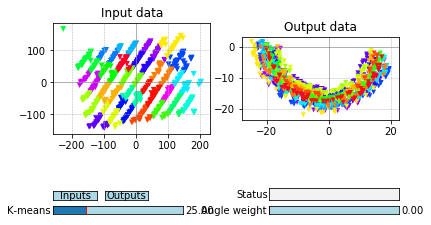

In [19]:
tb = ClusteringToolbox(data)
tb.calc_inputs_outputs_list()
tb.clustering()
tb.create_figure()
        